<a href="https://colab.research.google.com/github/JrrJrrJrr/MAI3002_Framingham/blob/main/GroupProject_MAI3002_Group6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MAI3002 - Group 6**
# Cleo Habets - i6337758
# Jerrica Pubben - i6276134
# Noura al Sayed - i6359287

# **Introduction**

## **Research questions**

Research question:

'Can changes in pulse pressure between Visit 1 and Visit 2 predict the occurrence of a CVD event before Visit 3 in Framingham participants?'

Subquestions:

1. Is the association between ΔPP and CVD different for women vs men?
2. Does a clinically simple threshold in ΔPP identify higher CVD risk by Visit 3?



# **Methods**

-----------------------------
Dataframe naming conventions
-----------------------------
| Component                 | Name |
---------------------------|------------------------------- |
| Raw long data             | cvd |
| After capping             | cvd_capped |
| Features + PP             | cvd_features|
| # Analytic (1 row/person) | analytic |
| ML features/labels        | X, y |
| Train/test splits         | X_train, X_test, y_train, y_test |
| Preproc pipeline          | preprocess (imputer + scaler + selector) |

# **Data preparation**

## **0. Libraries, config, load data**

In [ ]:
# ------------------------------------------------------------
# Installation helper
# ------------------------------------------------------------
import sys, subprocess

req_url = "https://raw.githubusercontent.com/JrrJrrJrr/MAI3002_Framingham/main/requirements.txt"

try:
    import google.colab
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", req_url])
except ImportError:
    print("Local environment: run manually if needed:")
    print(f"pip install -r {req_url}")

# ------------------------------------------------------------
# Imports
# ------------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import LinearSegmentedColormap
from sklearn.impute import SimpleImputer


In [ ]:
# Load dataset

cvd = pd.read_csv('https://raw.githubusercontent.com/LUCE-Blockchain/Databases-for-teaching/refs/heads/main/Framingham%20Dataset.csv')

print("Raw data shape:", cvd.shape) # Rows, columns
cvd.head()

# **Data exploration**

## **Data structure**

In [ ]:
# Column names, NN count, data type

cvd.info()

In [ ]:
# Numeric summary

cvd.describe().T

# 1. Helper functions
-> Central place so we donn't redefine things all over

## **Continuous crest colormap for sns**

In [ ]:
# Build a continuous crest colormap
crest_colors = sns.color_palette("crest", as_cmap=False)
crest_cmap = LinearSegmentedColormap.from_list("crest_cmap", crest_colors, N=256)

## Missing % per column, stratified by group_col

In [ ]:
def missing_by_group(df, group_col="PERIOD", columns=None, round_to=1):
    """Return % missing per column, stratified by group_col."""
    if columns is None:
        columns = df.columns.tolist()
    columns = [c for c in columns if c in df.columns]

    miss = (
        df.groupby(group_col)[columns]
        .apply(lambda d: d.isna().mean() * 100)
        .round(round_to)
    )
    return miss

## Missing by group (heatmap)

In [ ]:
def plot_missing_by_group(
        miss_by_group,
        group_col="PERIOD",
        cmap=crest_cmap,
        figsize=(8, 4),
        annotate=True
):
    """Heatmap of missingness by group (e.g. PERIOD)."""
    data = miss_by_group.T
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        data,
        annot=annotate,
        fmt=".1f",
        cmap=cmap,
        cbar_kws={"label": "% Missing"},
        ax=ax,
    )
    ax.set_title(f"Missingness by {group_col}", fontsize=13, pad=8)
    ax.set_xlabel(group_col)
    ax.set_ylabel("Variable")
    fig.tight_layout()
    plt.show()
    return fig, ax

## Numeric distribution (histograms)

In [ ]:
def plot_numeric_distributions(
    df,
    cols,
    bins=25,
    kde=True,
    palette="crest",
    figsize=(12, 6),
    ncols=4,
    stratify_by=None,
    suptitle="Distributions of Numeric Variables",
):
    """Grid of histograms (optionally stratified)."""
    n = len(cols)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True
    )
    axes = np.atleast_1d(axes).ravel()

    for i, col in enumerate(cols):
        ax = axes[i]
        if stratify_by and stratify_by in df.columns:
            sns.histplot(
                data=df,
                x=col,
                hue=stratify_by,
                bins=bins,
                kde=kde,
                element="step",
                common_norm=False,
                palette=palette,
                ax=ax,
            )
            ax.set_title(f"{col} by {stratify_by}", fontsize=11)
        else:
            sns.histplot(
                data=df,
                x=col,
                bins=bins,
                kde=kde,
                color=sns.color_palette(palette)[-1],
                edgecolor="black",
                ax=ax,
            )
            ax.set_title(col, fontsize=11)
        ax.set_xlabel("")
        ax.set_ylabel("Count")

    # Hide unused subplots if grid is larger than #cols
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    fig.suptitle(suptitle, fontsize=14, y=1.02)
    plt.show()
    return fig, axes

## Categorical distributions (countplots)

In [ ]:
def plot_categorical_distributions(
    df,
    cols,
    palette="crest",
    figsize=(12, 6),
    ncols=4,
    stratify_by=None,
    suptitle="Categorical Distributions",
    rotate_x=25,
    show_values=False,
):
    """Grid of countplots (optionally stratified by another variable)."""
    n = len(cols)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True
    )
    axes = np.atleast_1d(axes).ravel()

    for i, col in enumerate(cols):
        ax = axes[i]
        use_hue = stratify_by and (stratify_by in df.columns) and (stratify_by != col)
        hue_col = stratify_by if use_hue else None

        sns.countplot(
            data=df,
            x=col,
            hue=hue_col,
            palette=palette,
            ax=ax,
        )

        ax.set_title(
            f"{col}" + (f" by {hue_col}" if hue_col else ""),
            fontsize=11,
        )
        ax.set_xlabel("")
        ax.set_ylabel("Count")
        ax.tick_params(axis="x", rotation=rotate_x)

        if hue_col:
            if i == 0:
                ax.legend(
                    title=hue_col,
                    frameon=False,
                    fontsize=8,
                    title_fontsize=9,
                    loc="upper right",
                )
            else:
                ax.get_legend().remove()
        else:
            leg = ax.get_legend()
            if leg:
                leg.remove()

        if show_values:
            for container in ax.containers:
                ax.bar_label(container, fmt="%d", padding=2, fontsize=8)

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    fig.suptitle(suptitle, fontsize=14, y=1.02)
    plt.show()
    return fig, axes

## IQR-based outlier summary per variable

In [ ]:
def detect_outliers_iqr(df, columns=None, multiplier=1.5, sort=True, show_top=None):
    """IQR-based outlier summary per variable."""
    if columns is None:
        columns = df.select_dtypes(include=np.number).columns.tolist()

    summary = {}
    for col in columns:
        s = df[col].replace([np.inf, -np.inf], np.nan).dropna()
        if s.nunique() <= 1:
            continue

        Q1, Q3 = s.quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - multiplier * IQR, Q3 + multiplier * IQR
        n_outliers = ((s < lower) | (s > upper)).sum()
        pct_outliers = round(n_outliers / len(s) * 100, 2)

        summary[col] = {
            "Q1": Q1,
            "Q3": Q3,
            "IQR": IQR,
            "Lower_bound": lower,
            "Upper_bound": upper,
            "Outlier_count": n_outliers,
            "Percent_outliers": pct_outliers,
            "Valid_N": int(len(s)),
        }

    outlier_df = pd.DataFrame(summary).T
    if sort and not outlier_df.empty:
        outlier_df = outlier_df.sort_values("Percent_outliers", ascending=False)

    display(outlier_df.head(show_top) if show_top else outlier_df)
    return outlier_df

## Boxplots (IQR whiskers)

In [ ]:
def plot_boxplots_iqr(
    df,
    columns,
    multiplier=1.5,
    ncols=4,
    figsize_row=3.0,
    palette="crest",
    dashed_guides=True,
    suptitle="Outlier Inspection — Boxplots (IQR whiskers)",
):
    """Boxplots for a set of columns with optional IQR guide lines."""
    n = len(columns)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(4 * ncols, figsize_row * nrows),
        constrained_layout=True,
    )
    axes = np.atleast_1d(axes).ravel()

    color = sns.color_palette(palette)[-1]
    edgecolor = "0.25"

    for i, col in enumerate(columns):
        ax = axes[i]
        s = df[col].replace([np.inf, -np.inf], np.nan).dropna()
        if s.size == 0:
            ax.set_title(f"{col} (no data)")
            ax.axis("off")
            continue

        sns.boxplot(
            x=s,
            ax=ax,
            color=color,
            fliersize=2,
            linewidth=1.2,
            boxprops=dict(edgecolor=edgecolor),
            medianprops=dict(color=edgecolor),
            whiskerprops=dict(color=edgecolor),
            capprops=dict(color=edgecolor),
        )
        ax.set_title(col, fontsize=11)
        ax.set_xlabel("")

        if dashed_guides and s.nunique() > 1:
            Q1, Q3 = s.quantile([0.25, 0.75])
            IQR = Q3 - Q1
            lb = Q1 - multiplier * IQR
            ub = Q3 + multiplier * IQR
            ax.axvline(lb, ls="--", lw=1, color=edgecolor, alpha=0.7)
            ax.axvline(ub, ls="--", lw=1, color=edgecolor, alpha=0.7)

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    fig.suptitle(suptitle, fontsize=13, y=1.02)
    plt.show()
    return fig, axes

## % Outliers by group (e.g. PERIOD)

In [ ]:
def iqr_outlier_summary_by_group(df, columns, group_col="PERIOD", multiplier=1.5):
    """% outliers by group (e.g. PERIOD) for selected columns."""
    out = {}
    for g, sub in df.groupby(group_col):
        col_dict = {}
        for col in columns:
            if col not in sub.columns:
                continue
            s = sub[col].replace([np.inf, -np.inf], np.nan).dropna()
            if s.size <= 1:
                col_dict[col] = np.nan
                continue
            Q1, Q3 = s.quantile([0.25, 0.75])
            IQR = Q3 - Q1
            lb, ub = Q1 - multiplier * IQR, Q3 + multiplier * IQR
            pct = ((s < lb) | (s > ub)).mean() * 100
            col_dict[col] = round(pct, 1)
        out[g] = col_dict
    wide = pd.DataFrame(out).sort_index()
    return wide

## Heatmap of outlier % by group

In [ ]:
def plot_outliers_heatmap(
    wide_table,
    cmap=crest_cmap,
    title="IQR Outliers (%) by Group",
    figsize=(8, 4)
):
    """Heatmap of outlier % by group (rows=features, cols=groups)."""
    if wide_table.empty:
        print("No data to plot.")
        return None, None
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        wide_table,
        annot=True,
        fmt=".1f",
        cmap=cmap,
        cbar_kws={"label": "% Outliers"},
        ax=ax,
    )
    ax.set_title(title, fontsize=13, pad=8)
    ax.set_xlabel("Group")
    ax.set_ylabel("Feature")
    fig.tight_layout()
    plt.show()
    return fig, ax

## Boxplots by grouping variable (e.g. period)

In [ ]:
def plot_boxplots_by_group(
    df,
    columns,
    group_col="PERIOD",
    ncols=3,
    figsize_row=3.4,
    palette="crest",
    suptitle="Boxplots by Group",
):
    """Boxplots of each column by a grouping variable (e.g. PERIOD)."""
    n = len(columns)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(5 * ncols, figsize_row * nrows),
        constrained_layout=True,
    )
    axes = np.atleast_1d(axes).ravel()

    for i, col in enumerate(columns):
        ax = axes[i]
        if col not in df.columns or group_col not in df.columns:
            ax.set_title(f"{col} (missing)")
            ax.axis("off")
            continue

        sns.boxplot(
            data=df,
            x=group_col,
            y=col,
            palette=palette,
            ax=ax,
        )
        ax.set_title(f"{col} by {group_col}", fontsize=11)
        ax.set_xlabel(group_col)
        ax.set_ylabel(col)

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    fig.suptitle(suptitle, fontsize=13, y=1.02)
    plt.show()
    return fig, axes

# **2. Longitudinal structure: periods and participants**

## **Periods**

In [ ]:
# Period distribution

print("\nPERIOD distribution (rows):")
print(cvd['PERIOD'].value_counts().sort_index())

## Participants and number of visits

In [ ]:
# due to longitudinal nature of research:
# 1 participant can have multiple rows (max. 3)

n_participants = cvd['RANDID'].nunique()
visit_counts = cvd.groupby('RANDID')['PERIOD'].nunique()

print(f"\nUnique participants: {n_participants}")
print("\nVisits per participant (value counts):")
print(visit_counts.value_counts().sort_index())

In [ ]:
# Visual: barplot: number of examination cycles per participant

cvd['RANDID'].value_counts().value_counts().sort_index().plot(kind='bar')
plt.title('Number of examination cycles per participant')
plt.xlabel('Visits per participant')
plt.ylabel('Number of participants')
plt.show()

# **3. Missing data overview and analysis**

## **Missing data overview**

In [ ]:
# Overall missingness
missing = cvd.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(cvd) * 100).round(2)
missing_summary = pd.DataFrame({'Missing values': missing, '%': missing_pct})
missing_summary[missing_summary['Missing values'] > 0]

In [ ]:
# Visual: barplot: % missing per variable (non-zero only)

plt.figure(figsize=(10, 5))
nonzero_missing = missing_pct[missing_pct > 0]
sns.barplot(
    x=nonzero_missing,
    y=nonzero_missing.index,
    palette="crest"
)
plt.title("Missing Values by Variable (%)")
plt.xlabel("% Missing")
plt.ylabel("")
plt.tight_layout()
plt.show()

In [ ]:
# Missing (%) per column, stratified by PERIOD for selected variables

group_col = "PERIOD"
cols = [
    "LDLC",
    "HDLC",
    "GLUCOSE",
    "BPMEDS",
    "TOTCHOL",
    "educ",
    "CIGPDAY",
    "BMI",
    "HEARTRTE",
]

# Compute % missing by PERIOD
miss_by_period = missing_by_group(
    df=cvd, group_col=group_col, columns=cols, round_to=1
)

# Display table
display(miss_by_period)

#Plot heatmap
plot_missing_by_group(
    miss_by_period,
    group_col=group_col,
    cmap=crest_cmap,
    figsize=(8, 4),
    annotate=True,
)

## **Missingness interpretation (MCAR/MAR/MNAR)**

| Variable | % Missing | Interpretation |
|----------|------------|----------------|
| LDLC     | 73.97%     | MNAR (measured only in Period 3) |
| HDLC     | 73.97%     | MNAR (measured only in Period 3) |
| GLUCOSE  | 12.38%     | MAR (lab/patient-related) |
| BPMEDS   | 5.10%      | MCAR (random entry error) |
| TOTCHOL  | 3.52%      | MCAR |
| educ     | 2.54%      | MAR (sociodemographic) |
| CIGPDAY  | 0.68%      | MCAR |
| BMI      | 0.45%      | MCAR |
| HEARTRTE | 0.05%      | MCAR |

# **4. Distributions**

## **Numeric / categorical variables**

In [ ]:
# Numerical variables

num_vars = ['AGE','SYSBP','DIABP','BMI','TOTCHOL','GLUCOSE','CIGPDAY']

In [ ]:
# Categorical variables

cat_vars = ["SEX", "CURSMOKE", "DIABETES", "BPMEDS", "PREVHYP", "CVD", "PERIOD"]

## **Numeric distributions**

In [ ]:
# Visual: Overall numeric distributions (raw)

# Overall numeric distributions (raw)
plot_numeric_distributions(
    cvd,
    num_vars,
    kde=True,
    stratify_by=None,
    suptitle="Overall Numeric Distributions (raw)",
)

In [ ]:
# Visual: numeric distributions - Stratified by PERIOD (raw)

plot_numeric_distributions(
    cvd,
    num_vars,
    kde=True,
    stratify_by="PERIOD",
    suptitle="Numeric Distributions by PERIOD (raw)",
)

## **Categorical distribution**

In [ ]:
# Overall categorical distribution (raw)

plot_categorical_distributions(
    df=cvd,
    cols=cat_vars,
    stratify_by=None,
    palette="crest",
    show_values=True,
    suptitle="Overall Categorical Distributions",
)

In [ ]:
# Categorical distribution - Stratified by PERIOD (raw)

plot_categorical_distributions(
    df=cvd,
    cols=cat_vars,
    stratify_by="PERIOD",
    palette="crest",
    show_values=False,
    suptitle="Categorical Distributions by PERIOD",
)

# **Outliers**

## **Outlier detection**

In [ ]:
# Boxplots overall (raw)

plot_boxplots_iqr(cvd, columns=num_vars, multiplier=1.5, ncols=4)

In [ ]:
# Boxplots stratified by PERIOD (raw)

plot_boxplots_by_group(cvd, columns=num_vars, group_col='PERIOD', ncols=3)

In [ ]:
# Outlier summary - IQR method (raw)

outlier_summary = detect_outliers_iqr(cvd, columns=num_vars)

## **Outlier handling**

### **Ranges (clinically motivated)**

In [ ]:
# Defining clinically motivated ranges
# I have removed AGE and CIGPDAY from the ranges below: they do not need to be capped
# All AGE values (27 - 83) are plausible

cvd_capped = cvd.copy()

ranges = {
    "SYSBP": (80, 250),     # <80 = circulatory failure; >250 = critical hypertensive crisis
    "DIABP": (40, 140),     # <40 = severy hypotension; >140 = above hypertensive crisis thresholds
    "BMI": (15, 70),        # <15 = severe anorexia; >70 = extreme obesity, likely data entry artifact
    "TOTCHOL": (75, 600),       # <75 = hypocholesterolemia (only seen in severe liver disease or malnutrition); >600 = extreme familial hypercholesterolemia (extremely rare)
    "GLUCOSE": (40, 500),   # <40 = severe hypoglycemia; >500 = hyperglycemic crisis (>600 mostly flagged as measurement error)
    "CIGPDAY": (0, 90),     # 0 = subject doesn't smoke; >90 = extremely rare (entry error/misunderstanding?)
}

### **Winsorising outliers**

In [ ]:
# Winsorising/capping extreme values

for col, (low, high) in ranges.items():
    if col in cvd_capped.columns:
        cvd_capped[col] = cvd_capped[col].clip(lower=low, upper=high)

print("Extreme values capped within clinically defensible bounds → cvd_capped")

In [ ]:
# Summary: how many values were capped per variable

flag_summary = []
for col, (low, high) in ranges.items():
    if col in cvd.columns:
        below_low = (cvd[col] < low).sum()
        above_high = (cvd[col] > high).sum()
        total_capped = below_low + above_high
        flag_summary.append(
            {
                "Variable": col,
                "Below lower bound": below_low,
                "Above upper bound": above_high,
                "Total capped": total_capped,
            }
        )

flag_df = pd.DataFrame(flag_summary)
display(flag_df.sort_values("Total capped", ascending=False))

plt.figure(figsize=(7, 4))
sns.barplot(data=flag_df, x="Total capped", y="Variable", palette="crest")
plt.title("Number of Values Capped per Variable")
plt.xlabel("Count of Capped Observations")
plt.ylabel("")
plt.tight_layout()
plt.show()

In [ ]:
# Summary: by PERIOD on capped data (Table + heatmap)

# Table
wide = iqr_outlier_summary_by_group(
    cvd_capped, columns=num_vars, group_col="PERIOD", multiplier=1.5
)
display(wide)

# Heatmap
plot_outliers_heatmap(
    wide, title="IQR Outliers (%) by PERIOD after capping", figsize=(8, 4)
)

In [ ]:
# Summary: by PERIOD on capped data (Boxplots)

plot_boxplots_by_group(

    cvd_capped,
    columns=num_vars,
    group_col="PERIOD",
    ncols=3,
    suptitle="Boxplots by PERIOD after capping",
)

## **Outcome imbalance**

In [ ]:
# Only select PERIOD 3

cvd_period3 = cvd_capped[cvd_capped['PERIOD'] == 3]

In [ ]:
# Outcomes occur at visit 3 only

for outcome in ['CVD', 'STROKE', 'ANYCHD', 'HYPERTEN', 'DEATH']:
    if outcome in cvd_period3.columns:
        counts = cvd_period3[outcome].value_counts(dropna=False)
        pct_pos = (counts.get(1, 0) / len(cvd_period3) * 100).round(2)

        print(f"\n{outcome} at visit 3:")
        print(counts)
        print(f"Percent positive: {pct_pos}%")

In [ ]:
# Visual + table: CVD Outcome distribution (PRIMARY OUTCOME)

# Countplot
sns.countplot(data=cvd_period3, x='CVD', palette='crest')
plt.title('CVD Outcome Distribution (visit 3 Only)')
plt.xlabel('CVD (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

# Table
cvd_period3['CVD'].value_counts(normalize=True).mul(100).round(2)

## **Correlation and relationships**

## **Period and variable selection**

In [ ]:
# BASELINE (only PERIOD 1)
cvd_period1 = cvd_capped[cvd_capped['PERIOD'] == 1].copy()

# Relevant continuous variables
cont_vars = ['AGE','SYSBP','DIABP','BMI','TOTCHOL','GLUCOSE']

## **Correlation matrix**

In [ ]:
# Correlation matrix on BASELINE data (only PERIOD 1)
plt.figure(figsize=(10,8))
corr = cvd_period1[cont_vars].corr()
sns.heatmap(
    corr,
    annot=True,
    cmap='vlag',
    center=0)
plt.title('Correlation Matrix of continuous variables (BASELINE period 1)')
plt.show()

In [ ]:
# Relationship plots (scatterplot + regression line) (BASELINE only)
pairs = [
    ('AGE','SYSBP'),
    ('BMI','SYSBP'),
    ('TOTCHOL','GLUCOSE'),
    ('AGE','BMI')
]

# Colour palette to match the rest
crest_color_scatter = sns.color_palette("crest")[1]
crest_color_reg = sns.color_palette("crest")[5]

for x, y in pairs:
    plt.figure(figsize=(6,4))
    sns.scatterplot(
        data=cvd_period1,
        x=x,
        y=y,
        color=crest_color_scatter,
        alpha=0.4,
        edgecolor=None)
    sns.regplot(
        data=cvd_period1,
        x=x,
        y=y,
        scatter=False,
        color=crest_color_reg,
        line_kws={'linewidth':1.5}
    )
    plt.title(f'{x} vs {y} (Baseline period 1)')
    plt.tight_layout()
    plt.show()

In [ ]:
# Pairplot (BASELINE only)
sns.pairplot(cvd_period1[cont_vars],
             diag_kind='kde',
             corner=True,
             plot_kws=dict(color=crest_color_scatter, alpha=0.4),
             diag_kws=dict(color=crest_color_reg, linewidth=1.5)
             )
plt.suptitle('Pairwise relationships (BASELINE period 1)', y=1.02)
plt.show()

# **Data cleaning (EDA ONLY)**

## **1. Missingness overview on capped data**

In [ ]:
# 1. Missingness overview on capped data
missing_pct = (cvd_capped.isna().mean() * 100).round(2)
display(missing_pct[missing_pct > 0].sort_values(ascending=False))

# Make a working copy for imputation (EDA-level)
cvd_imputed = cvd_capped.copy()

## **Missingness analysis**

| Variable | % Missing | Interpretation |
|-----------|------------|----------------|
| LDLC | 73.97| Measured only in Period 3 → structural missingness (MNAR) |
| HDLC | 73.97| Measured only in Period 3 → structural missingness (MNAR) |
| GLUCOSE | 12.38 | Low lab missingness → patient or lab factors (MAR) |
| BPMEDS | 5.10| Almost complete → random entry error (MCAR)|
| TOTCHOL | 3.52 | Negligible missingness → lab factors? (MCAR)|
| educ | 2.54 | Minor sociodemographic missingness → nonresponsesoci (likely MAR) |
|CIGPDAY|0.68| Random nonresponse (MCAR)|
| BMI | 0.45 | Random recording or measurement (MCAR)|
|HEARTRTE| 0.05|Ignorable, almost complete|


**Interpretation:**  

**MCAR (Completely at Random)**

Data are missing by chance; imputation has minimal bias risk (e.g., BMI, TOTCHOL, BPMEDS).

**MAR (At Random)**

Missingness is related to other observed variables but not to the missing value itself (e.g., education, glucose). Median or model-based imputation is sufficient.

**MNAR (Not at Random)**
  
Missingness is due to study design or unobserved factors (HDLC, LDLC). Imputation would distort meaning; Variables should be excluded or analyzed separately (Period 3 subset).



## **2. Define columns for imputation**

In [ ]:
# 2. Define columns for imputation
num_cols = ['GLUCOSE', 'TOTCHOL', 'CIGPDAY', 'BMI', 'HEARTRTE']
cat_cols = ['BPMEDS', 'educ']

# Safety: keep only columns that actually exist (in case of prior changes)
num_cols = [c for c in num_cols if c in cvd_imputed.columns]
cat_cols = [c for c in cat_cols if c in cvd_imputed.columns]

## **3. Drop MNAR / design-missing variables (HDLC, LDLC are essentially Period-3 only)**

In [ ]:
# 3. Drop MNAR / design-missing variables (HDLC, LDLC are essentially Period-3 only)
exclude_vars = ['HDLC', 'LDLC']
cvd_imputed = cvd_imputed.drop(columns=exclude_vars, errors='ignore')

## **4. Define imputers**

In [ ]:
# 4. Define imputers
imp_median = SimpleImputer(strategy='median')
imp_mode   = SimpleImputer(strategy='most_frequent')

## **5. Apply imputers to selected columns**

In [ ]:
# 5. Apply imputers to selected columns
if num_cols:
    cvd_imputed[num_cols] = imp_median.fit_transform(cvd_imputed[num_cols])

if cat_cols:
    cvd_imputed[cat_cols] = imp_mode.fit_transform(cvd_imputed[cat_cols])

print(f"Dropped MNAR variables: {exclude_vars}")
print("Remaining missing values (all columns):", int(cvd_imputed.isna().sum().sum()))

## **6. Remaining missingness per column**

In [ ]:
# 6. Remaining missingness per column
remaining_missing = cvd_imputed.isna().mean().mul(100).round(2)
display(remaining_missing[remaining_missing > 0])

## **7. Distribution plots after imputation**

In [ ]:
# 7. Visual: Distribution plots after imputation
plot_numeric_distributions(
    df=cvd_imputed,
    cols=['GLUCOSE', 'TOTCHOL', 'CIGPDAY', 'BMI'],
    kde=True,
    stratify_by='PERIOD',
    palette='crest'
)

## **8. Recode binary variables and SEX**

In [ ]:
# 8. Recode binary variables and SEX

# Identify binary columns: only {0,1} and not missing
binary_cols = [
    c for c in cvd_imputed.columns
    if set(cvd_imputed[c].dropna().unique()) <= {0, 1}
]

# Convert all binary columns to int for consistency
cvd_imputed[binary_cols] = cvd_imputed[binary_cols].astype(int)

# SEX recoding (dataset default: 1=Male, 2=Female)
if 'SEX' in cvd_imputed.columns:
    cvd_imputed['SEX'] = cvd_imputed['SEX'].map({1: 0, 2: 1}).astype(int)
    print("SEX recoded: 0 = Male, 1 = Female")
    print("\nSEX value counts after recode:")
    print(cvd_imputed['SEX'].value_counts(dropna=False))

print(f"\nBinary columns standardized: {len(binary_cols)}")

# Quick structural check
cvd_imputed.info()

## **9. Visuals: numeric distributions**

In [ ]:
num_cols_plot = ['AGE', 'SYSBP', 'DIABP', 'BMI', 'TOTCHOL', 'GLUCOSE', 'CIGPDAY']

In [ ]:
# 9a. Overall numeric distributions post-cleaning (whole cohort)
plot_numeric_distributions(
    df=cvd_imputed,
    cols=num_cols_plot,
    kde=True,
    stratify_by=None,
    palette='crest'
)

In [ ]:
# 9b. Numeric distributions by PERIOD (to see time trends)
plot_numeric_distributions(
    df=cvd_imputed,
    cols=num_cols_plot,
    kde=True,
    stratify_by='PERIOD',
    palette='crest'
)

In [ ]:
# Check check double check remaining missingness
cvd_imputed.isnull().sum()

## **Log transformation**

Data still shows skewness after imputation. Use log1p (log(x+1)) for transformation as it takes 0 into account.

CIGPDAY will not change much because of very high zero count. We can consider binning this or use binary variable (0=Non-smoker, 1=smoker).

In [ ]:
# Log1p transformation

cvd_imputed['GLUCOSE_LOG'] = np.log1p(cvd_imputed['GLUCOSE'])
cvd_imputed['CIGPDAY_LOG'] = np.log1p(cvd_imputed['CIGPDAY'])
cvd_imputed['TOTCHOL_LOG'] = np.log1p(cvd_imputed['TOTCHOL'])

In [ ]:
# Visual: log transformed variables

plot_numeric_distributions(
    cvd_imputed,
    ['GLUCOSE_LOG', 'CIGPDAY_LOG', 'TOTCHOL_LOG'],
    kde=True
)

# **Feature engineering**

## **New var: pulse pressure variable**

* Represents arterial stiffness
* High (>60 mmHg) is linked to increased cvd risk (especially with increasing age)
* We will look at the difference (delta, Δ) of pulse pressure between period 1 and 2 to predict CVD in period 3


**Pulse pressure = systolic blood pressure - diastolic blood pressure**

In [ ]:
# **Feature engineering: Pulse Pressure, ΔPP, analytic dataset**
# 1. Working copy after cleaning/imputation
cvd_features = cvd_imputed.copy()

# 2. Create pulse pressure (PP = SYSBP − DIABP) for each row
cvd_features['PULSE_PRESSURE'] = cvd_features['SYSBP'] - cvd_features['DIABP']

print("Pulse pressure summary (all periods):")
print(cvd_features['PULSE_PRESSURE'].describe().round(2))

In [ ]:
# 2a. Visual: quick PP sanity plot
sns.histplot(
    data=cvd_features,
    x='PULSE_PRESSURE',
    bins=30,
    kde=True,
    color=sns.color_palette("crest")[4]
)
plt.title("Distribution of Pulse Pressure (all periods)")
plt.xlabel("PULSE_PRESSURE (SYSBP − DIABP)")
plt.tight_layout()
plt.show()

## **Wide format**

In [ ]:
# 3. Build wide format: PP1, PP2, PP3 per participant
pp_wide = (
    cvd_features[['RANDID', 'PERIOD', 'PULSE_PRESSURE']]
    .dropna(subset=['PULSE_PRESSURE'])
    .drop_duplicates(['RANDID', 'PERIOD'])  # safety: 1 row per RANDID/PERIOD
    .pivot(index='RANDID', columns='PERIOD', values='PULSE_PRESSURE')
    .rename(columns={1: 'PP1', 2: 'PP2', 3: 'PP3'})
)

print("PP wide shape:", pp_wide.shape)
pp_wide.head()

## **Compute ΔPP = PP2 − PP1**

In [ ]:
# 4. Compute ΔPP = PP2 − PP1, keep only participants with both visits
pp_delta = (
    pp_wide[['PP1', 'PP2']]
    .dropna()  # require both V1 & V2
    .assign(DELTA_PP=lambda d: d['PP2'] - d['PP1'])
    .reset_index()
)

print("Participants with PP1 & PP2:", pp_delta['RANDID'].nunique())
pp_delta[['DELTA_PP']].describe()

## **Primary endpoint (Outcome visit 3)**

In [ ]:
# 5. Outcome at visit 3: CVD (primary endpoint)
outcome_v3 = (
    cvd_features.loc[cvd_features['PERIOD'] == 3, ['RANDID', 'CVD']]
      .drop_duplicates('RANDID')
)

print("Participants with CVD outcome at visit 3:", outcome_v3['RANDID'].nunique())

## **Baseline covariates visit 1**

In [ ]:
# 6. Baseline covariates from Visit 1
baseline_v1 = (
    cvd_features.loc[cvd_features['PERIOD'] == 1,
                     ['RANDID', 'AGE', 'SEX', 'BMI',
                      'SYSBP', 'DIABP', 'GLUCOSE', 'TOTCHOL', 'CIGPDAY']]
      .drop_duplicates('RANDID')
      .add_prefix('V1_')
      .rename(columns={'V1_RANDID': 'RANDID'})
)

print("Baseline V1 rows:", baseline_v1.shape[0])

## **Final analytic dataset for ML**

In [ ]:
# 7. Final analytic dataset (1 row per person)
analytic = (
    pp_delta
      .merge(outcome_v3, on='RANDID', how='inner')   # require CVD outcome at Visit 3
      .merge(baseline_v1, on='RANDID', how='left')   # add baseline features
)

print("\nFINAL analytic dataset shape:", analytic.shape)
analytic.head()

# **Analytic dataset: overview**

In [ ]:
# Class balance (analytic only)
print("CVD class counts (analytic):")
print(analytic['CVD'].value_counts())

print("\nCVD class balance (%):")
print(
    analytic['CVD']
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
)

In [ ]:
# ΔPP distribution by CVD
print("\nΔPP summary (analytic):")
print(analytic['DELTA_PP'].describe().round(2))

# Visual: boxplot
sns.boxplot(data=analytic, x='CVD', y='DELTA_PP', palette='crest')
plt.title('Change in Pulse Pressure (ΔPP) by CVD Outcome (analytic)')
plt.xlabel('CVD (0 = No, 1 = Yes)')
plt.ylabel('ΔPP (PP2 − PP1, mmHg)')
plt.tight_layout()
plt.show()

In [ ]:
# Visual: correlation among ΔPP and key baseline variables
corr_vars = ['DELTA_PP', 'V1_AGE', 'V1_BMI', 'V1_SYSBP', 'V1_DIABP']
corr_table = analytic[corr_vars].corr().round(2)

plt.figure(figsize=(5, 4))
sns.heatmap(corr_table, annot=True, cmap=crest_cmap, center=0)
plt.title('Correlation among ΔPP and baseline variables (analytic)')
plt.tight_layout()
plt.show()

## **Machine Learning**

# **Setup**

In [309]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay,
    confusion_matrix,
)
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow import keras
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

## **Define feature set**

In [ ]:
# 1. Define feature set
feature_cols = [
    "DELTA_PP",
    "V1_AGE",
    "V1_SEX",
    "V1_BMI",
    "V1_SYSBP",
    "V1_DIABP",
    "V1_GLUCOSE",
    "V1_TOTCHOL",
    "V1_CIGPDAY",
]

## **Target design**

In [ ]:
# 2. Design matrix X and target y
X = analytic[feature_cols].copy()
y = analytic["CVD"].copy()

print("X shape:", X.shape)
print("Outcome positive rate (CVD=1):", y.mean().round(3))

## **Train/test split (stratified)**

In [ ]:
# 3. Train/test split (stratified because of imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=3002,
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

# **Preprocessing pipeline (numeric imputer + scaler)**

In [ ]:
# Features we use in the model
feature_cols = [
    "DELTA_PP",
    "V1_AGE",
    "V1_SEX",
    "V1_BMI",
    "V1_SYSBP",
    "V1_DIABP",
    "V1_GLUCOSE",
    "V1_TOTCHOL",
    "V1_CIGPDAY",
]

# Subsets: which ones to log, which to keep linear
log_features = ["V1_GLUCOSE", "V1_TOTCHOL", "V1_CIGPDAY"]
linear_features = [f for f in feature_cols if f not in log_features]

# 1. Transformer for linear numeric features: impute + scale
linear_numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

# 2. Transformer for log-transformed features: impute + log1p + scale
log_numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("log", FunctionTransformer(np.log1p)),
        ("scaler", StandardScaler()),
    ]
)

# 3. ColumnTransformer that applies the right block to each group
preprocess = ColumnTransformer(
    transformers=[
        ("num_linear", linear_numeric_transformer, linear_features),
        ("num_log", log_numeric_transformer, log_features),
    ]
)

## **Helper function: unified evaluation**

In [ ]:
# Unified evaluation function
def evaluate_classifier(name, clf, X_train, X_test, y_train, y_test):
    """
    Fit classifier, compute metrics on test set, and plot confusion matrix + ROC curve.
    """
    # Fit on training data only
    clf.fit(X_train, y_train)

    # Predictions
    y_pred = clf.predict(X_test)

    # Some models (e.g. SVM with no probas) won't have predict_proba
    if hasattr(clf, "predict_proba"):
        y_proba = clf.predict_proba(X_test)[:, 1]
    else:
        # Fallback: use decision_function, squeeze to [0,1] via rank / min-max if needed.
        # For now: simple placeholder that avoids crashing.
        y_scores = clf.decision_function(X_test)
        # crude min-max scaling to approx [0,1]
        y_proba = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    print(f"\n-- {name} --")
    print("Accuracy (test):", round(acc, 3))
    print("ROC AUC (test):", round(auc, 3))
    print("\nClassification report (test):")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=clf.classes_,
    )
    disp.plot(cmap='crest')
    plt.title(f"Confusion Matrix — {name}")
    plt.tight_layout()
    plt.show()

    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot([0, 1], [0, 1], "k--")
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate (Recall)")
    plt.title(f"ROC Curve — {name}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    return acc, auc

# **ML Models**

In [ ]:
# Global result storage for comparison table
model_results = []

In [ ]:
# Shared stratified CV splitter (reused across all models)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## **Model 1. Logistic regression (baseline)**

In [ ]:
# 1. LR (baseline)
logreg_pipe = Pipeline(
    steps=[
        ("preprocess", preprocess),
        (
            "model",
            LogisticRegression(
                max_iter=1000,
                class_weight="balanced",  # account for CVD imbalance
                solver="lbfgs",
                penalty="l2",
            ),
        ),
    ]
)

logreg_param_grid = {
    "model__C": [0.01, 0.1, 1, 10],
}

logreg_grid = GridSearchCV(
    estimator=logreg_pipe,
    param_grid=logreg_param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0,
)

logreg_grid.fit(X_train, y_train)

print("Logistic Regression – best CV AUC:", round(logreg_grid.best_score_, 3))
print("Logistic Regression – best params:", logreg_grid.best_params_)

best_logreg = logreg_grid.best_estimator_

logreg_acc, logreg_auc = evaluate_classifier(
    name="Logistic Regression (tuned)",
    clf=best_logreg,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
)

model_results.append({
    "ID": 1,
    "Model": "Logistic Regression (tuned)",
    "Type": "linear",
    "Accuracy": logreg_acc,
    "ROC_AUC": logreg_auc,
})

## **Model 2. Decision Tree**

In [ ]:
# 2. Decision Tree
dt_pipe = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", DecisionTreeClassifier(class_weight="balanced", random_state=42)),
    ]
)

dt_param_grid = {
    "model__max_depth": [3, 5, 7, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 5],
}

dt_grid = GridSearchCV(
    estimator=dt_pipe,
    param_grid=dt_param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0,
)

dt_grid.fit(X_train, y_train)

print("Decision Tree – best CV AUC:", round(dt_grid.best_score_, 3))
print("Decision Tree – best params:", dt_grid.best_params_)

best_dt = dt_grid.best_estimator_

dt_acc, dt_auc = evaluate_classifier(
    name="Decision Tree (tuned)",
    clf=best_dt,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
)

model_results.append({
    "ID": 2,
    "Model": "Decision Tree (tuned)",
    "Type": "tree",
    "Accuracy": dt_acc,
    "ROC_AUC": dt_auc,
})

## **Model 3. Random Forest**

In [ ]:
# 3. RF
rf_pipe = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", RandomForestClassifier(
            class_weight="balanced",
            random_state=42,
        )),
    ]
)

rf_param_grid = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [5, 10, None],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2],
    "model__max_features": ["sqrt", "log2"],
}

rf_grid = GridSearchCV(
    estimator=rf_pipe,
    param_grid=rf_param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0,
)

rf_grid.fit(X_train, y_train)

print("Random Forest – best CV AUC:", round(rf_grid.best_score_, 3))
print("Random Forest – best params:", rf_grid.best_params_)

best_rf = rf_grid.best_estimator_

rf_acc, rf_auc = evaluate_classifier(
    name="Random Forest (tuned)",
    clf=best_rf,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
)

model_results.append({
    "ID": 3,
    "Model": "Random Forest (tuned)",
    "Type": "tree_ensemble",
    "Accuracy": rf_acc,
    "ROC_AUC": rf_auc,
})



## **Model 4. KNN**

In [ ]:
# 4. KNN

knn_pipe = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", KNeighborsClassifier()),
    ]
)

knn_param_grid = {
    "model__n_neighbors": [3, 5, 7, 9],
    "model__weights": ["uniform", "distance"],
    "model__p": [1, 2],  # 1 = Manhattan, 2 = Euclidean
}

knn_grid = GridSearchCV(
    estimator=knn_pipe,
    param_grid=knn_param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0,
)

knn_grid.fit(X_train, y_train)

print("KNN – best CV AUC:", round(knn_grid.best_score_, 3))
print("KNN – best params:", knn_grid.best_params_)

best_knn = knn_grid.best_estimator_

knn_acc, knn_auc = evaluate_classifier(
    name="KNN (tuned)",
    clf=best_knn,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
)

model_results.append({
    "ID": 4,
    "Model": "KNN (tuned)",
    "Type": "distance",
    "Accuracy": knn_acc,
    "ROC_AUC": knn_auc,
})



## **Model 5. Linear SVM**

In [ ]:
# 5. SVM


# ============================================================
# Model 5: Linear SVM (tuned with CV)
# ============================================================

svm_pipe = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", SVC(
            kernel="rbf",
            probability=True,        # needed for ROC AUC
            class_weight="balanced",
            random_state=42,
        )),
    ]
)

svm_param_grid = {
    "model__C": [0.1, 1, 10],
    "model__gamma": ["scale", 0.1, 0.01],
}

svm_grid = GridSearchCV(
    estimator=svm_pipe,
    param_grid=svm_param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0,
)

svm_grid.fit(X_train, y_train)

print("SVM (RBF) – best CV AUC:", round(svm_grid.best_score_, 3))
print("SVM (RBF) – best params:", svm_grid.best_params_)

best_svm = svm_grid.best_estimator_

svm_acc, svm_auc = evaluate_classifier(
    name="SVM (RBF, tuned)",
    clf=best_svm,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
)

model_results.append({
    "ID": 5,
    "Model": "SVM (RBF, tuned)",
    "Type": "margin",
    "Accuracy": svm_acc,
    "ROC_AUC": svm_auc,
})

## **Model 6. Gradient Boosting Classifier**

In [ ]:
# 6. GB
gb_pipe = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", GradientBoostingClassifier(random_state=42)),
    ]
)

gb_param_grid = {
    "model__n_estimators": [100, 200],
    "model__learning_rate": [0.01, 0.1],
    "model__max_depth": [2, 3],
}

gb_grid = GridSearchCV(
    estimator=gb_pipe,
    param_grid=gb_param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0,
)

gb_grid.fit(X_train, y_train)

print("Gradient Boosting – best CV AUC:", round(gb_grid.best_score_, 3))
print("Gradient Boosting – best params:", gb_grid.best_params_)

best_gb = gb_grid.best_estimator_

gb_acc, gb_auc = evaluate_classifier(
    name="Gradient Boosting (tuned)",
    clf=best_gb,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
)

model_results.append({
    "ID": 6,
    "Model": "Gradient Boosting (tuned)",
    "Type": "tree_ensemble",
    "Accuracy": gb_acc,
    "ROC_AUC": gb_auc,
})

## **Model 7. Neural Network (Multi-layer perceptron)**

In [ ]:
# 7. Neural Network (Multi-Layer Perceptron)


mlp_pipe = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", MLPClassifier(
            max_iter=500,
            random_state=42,
        )),
    ]
)

mlp_param_grid = {
    "model__hidden_layer_sizes": [(32,), (64, 32), (64, 32, 16)],
    "model__alpha": [0.0001, 0.001, 0.01],   # L2 regularization
    "model__learning_rate_init": [0.001, 0.01],
}

mlp_grid = GridSearchCV(
    estimator=mlp_pipe,
    param_grid=mlp_param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0,
)

mlp_grid.fit(X_train, y_train)

print("MLP – best CV AUC:", round(mlp_grid.best_score_, 3))
print("MLP – best params:", mlp_grid.best_params_)

best_mlp = mlp_grid.best_estimator_

nn_acc, nn_auc = evaluate_classifier(
    name="Neural Network (MLP, tuned)",
    clf=best_mlp,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
)
model_results.append({
    "ID": 7,
    "Model": "Neural Network (MLP, tuned)",
    "Type": "neural_net",
    "Accuracy": nn_acc,
    "ROC_AUC": nn_auc,
})

## **Model 8. DummyClassifier (reference)**

In [ ]:
# Model 8: Dummy baseline (no tuning, but same API)

dummy_pipe = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", DummyClassifier(strategy="most_frequent")),
    ]
)

dummy_acc, dummy_auc = evaluate_classifier(
    name="Dummy (most frequent)",
    clf=dummy_pipe,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
)

model_results.append({
    "ID": 8,
    "Model": "Dummy (most frequent)",
    "Type": "baseline",
    "Accuracy": dummy_acc,
    "ROC_AUC": dummy_auc,
})

## **Model 9. NN TensorFlow**

In [318]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from tensorflow import keras


class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    """
    A scikit-learn compatible wrapper for Keras models.

    build_fn must be a function with signature:
        build_fn(input_dim, n_classes, learning_rate, hidden_units1,
                 hidden_units2, dropout_rate) -> compiled keras.Model
    """

    def __init__(
        self,
        build_fn,
        epochs=10,
        batch_size=None,
        verbose=0,
        # Model-building hyperparameters (explicit for sklearn)
        input_dim=None,
        n_classes=2,
        learning_rate=0.001,
        hidden_units1=64,
        hidden_units2=32,
        dropout_rate=0.2,
    ):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose

        # these must be attributes so GridSearchCV can see/clone them
        self.input_dim = input_dim
        self.n_classes = n_classes
        self.learning_rate = learning_rate
        self.hidden_units1 = hidden_units1
        self.hidden_units2 = hidden_units2
        self.dropout_rate = dropout_rate

        self._model = None
        self.classes_ = None   # will be set in fit

    def _build_model(self):
        if self.input_dim is None:
            raise ValueError("input_dim must be set before fitting the model.")

        model = self.build_fn(
            input_dim=self.input_dim,
            n_classes=self.n_classes,
            learning_rate=self.learning_rate,
            hidden_units1=self.hidden_units1,
            hidden_units2=self.hidden_units2,
            dropout_rate=self.dropout_rate,
        )
        if not isinstance(model, keras.Model):
            raise ValueError("build_fn must return a compiled keras.Model")
        return model

    def fit(self, X, y, **fit_params):
        X = np.asarray(X, dtype="float32")
        y = np.asarray(y)

        # store class labels in sklearn-style attribute
        # sorted so we get [0, 1] for binary problems
        self.classes_ = np.unique(y)

        # build (or rebuild) model
        self._model = self._build_model()

        self._model.fit(
            X,
            y,
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=self.verbose,
            **fit_params,
        )
        return self

    def predict_proba(self, X):
        X = np.asarray(X, dtype="float32")
        if self._model is None:
            raise RuntimeError("You must call fit before predict_proba.")
        proba = self._model.predict(X, verbose=0)

        # Ensure 2D output (n_samples, n_classes)
        if proba.ndim == 1:
            # assume proba = P(class 1)
            proba = np.stack([1 - proba, proba], axis=1)
        elif proba.shape[1] == 1:
            # (n,1) -> (n,2)
            proba_pos = proba[:, 0]
            proba = np.stack([1 - proba_pos, proba_pos], axis=1)

        return proba

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

    def score(self, X, y):
        from sklearn.metrics import accuracy_score

        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

/Users/jerr/PycharmProjects/PythonProject/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jerr/PycharmProjects/PythonProject/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jerr/PycharmProjects/PythonProject/.venv/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jerr/PycharmProjects/PythonProject/.venv/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
        estimator,
    ...<2 lines>...
        p

TensorFlow NN – best CV AUC: nan
TensorFlow NN – best params: {'model__batch_size': 32, 'model__epochs': 30}

-- Neural Network (TensorFlow, tuned) --
Accuracy (test): 0.78
ROC AUC (test): 0.734

Classification report (test):
              precision    recall  f1-score   support

           0       0.80      0.94      0.87       492
           1       0.57      0.25      0.34       150

    accuracy                           0.78       642
   macro avg       0.69      0.59      0.61       642
weighted avg       0.75      0.78      0.75       642



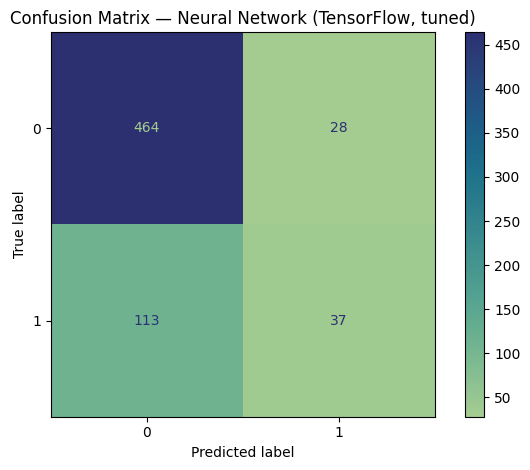

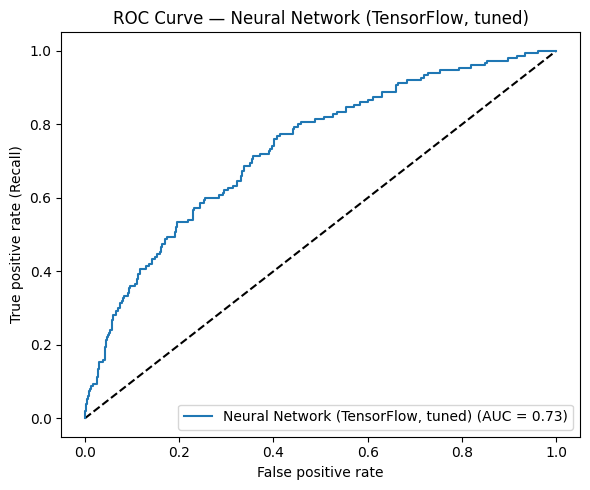

In [319]:
# 9. NN TensorFlow

# Keras builder function for the wrapper
def build_tf_model(input_dim,
                   n_classes=2,
                   learning_rate=0.001,
                   hidden_units1=64,
                   hidden_units2=32,
                   dropout_rate=0.2
                   ):
    """
    Simple feedforward network for binary classification.
    input_dim: number of input features (after preprocessing).
    n_classes: 2 for binary CVD (output is sigmoid).
    """
    model = keras.Sequential([
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(hidden_units1, activation="relu"),
        keras.layers.Dense(hidden_units2, activation="relu"),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(1, activation="sigmoid"),  # binary outcome
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="AUC")],
    )
    return model

# All selected features are numeric; preprocess does not change #columns
input_dim = len(feature_cols)

tf_nn_pipe = Pipeline(
    steps=[
        ("preprocess", preprocess),
        (
            "model",
            KerasClassifierWrapper(
                build_fn=build_tf_model,
                epochs=40,          # default; will be tuned
                batch_size=32,      # default; will be tuned
                verbose=0,
                input_dim=input_dim,
                n_classes=2,
                learning_rate=0.001,
                hidden_units1=64,
                hidden_units2=32,
                dropout_rate=0.2,
            ),
        ),
    ]
)

tf_param_grid = {
    "model__epochs": [30, 50],
    "model__batch_size": [32, 64],
}

tf_grid = GridSearchCV(
    estimator=tf_nn_pipe,
    param_grid=tf_param_grid,
    scoring="roc_auc",
    cv=cv,        # StratifiedKFold
    n_jobs=1,
    refit=True,
    verbose=0,
)

tf_grid.fit(X_train, y_train)

print("TensorFlow NN – best CV AUC:", round(tf_grid.best_score_, 3))
print("TensorFlow NN – best params:", tf_grid.best_params_)

best_tf_nn = tf_grid.best_estimator_

tf_acc, tf_auc = evaluate_classifier(
    name="Neural Network (TensorFlow, tuned)",
    clf=best_tf_nn,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
)

model_results.append({
    "ID": 9,
    "Model": "Neural Network (TensorFlow, tuned)",
    "Type": "neural_net",
    "Accuracy": tf_acc,
    "ROC_AUC": tf_auc,
})

# **Model results**

In [320]:
# Build comparison table from all stored model results
results_df = pd.DataFrame(model_results)

# Sort by ROC_AUC (best model at the top)
results_sorted = results_df.sort_values("ROC_AUC", ascending=False).reset_index(drop=True)

print("Model comparison (sorted by ROC_AUC):")
display(results_sorted)

Model comparison (sorted by ROC_AUC):


,ID,Model,Type,Accuracy,ROC_AUC
0,5,Linear SVM,margin,0.655763,0.745840
1,1,Logistic Regression,linear,0.668224,0.745420
2,1,Logistic Regression,linear,0.668224,0.745420
3,1,Logistic Regression (tuned),linear,0.666667,0.745325
4,1,Logistic Regression (tuned),linear,0.666667,0.745325
5,1,Logistic Regression (tuned),linear,0.666667,0.745325
6,5,"SVM (RBF, tuned)",margin,0.646417,0.741355
7,9,Neural Network (TensorFlow),neural_net,0.638629,0.737669
8,3,Random Forest (tuned),tree_ensemble,0.657321,0.736626
9,3,Random Forest (tuned),tree_ensemble,0.657321,0.736626


In [321]:
# Results already in `results_df`

# 1) Drop exact duplicates (same ID + Model + metrics)
results_df_clean = results_df.drop_duplicates(
    subset=["ID", "Model", "Accuracy", "ROC_AUC"]
).copy()

# 2) Sort by ROC AUC (descending)
plot_df = results_df_clean.sort_values("ROC_AUC", ascending=False).reset_index(drop=True)

plot_df

,ID,Model,Type,Accuracy,ROC_AUC
0,5,Linear SVM,margin,0.655763,0.745840
1,1,Logistic Regression,linear,0.668224,0.745420
2,1,Logistic Regression (tuned),linear,0.666667,0.745325
3,5,"SVM (RBF, tuned)",margin,0.646417,0.741355
4,9,Neural Network (TensorFlow),neural_net,0.638629,0.737669
5,3,Random Forest (tuned),tree_ensemble,0.657321,0.736626
6,7,"Neural Network (MLP, tuned)",neural_net,0.777259,0.736138
7,6,Gradient Boosting (tuned),tree_ensemble,0.766355,0.734695
8,9,Neural Network (TensorFlow),neural_net,0.633956,0.734228
9,3,Random Forest,tree_ensemble,0.682243,0.733970


## **ROC AUC ranked by model**

/var/folders/2m/1q25kl316j3ghdz7jsv_vcb00000gn/T/ipykernel_22300/3698655435.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


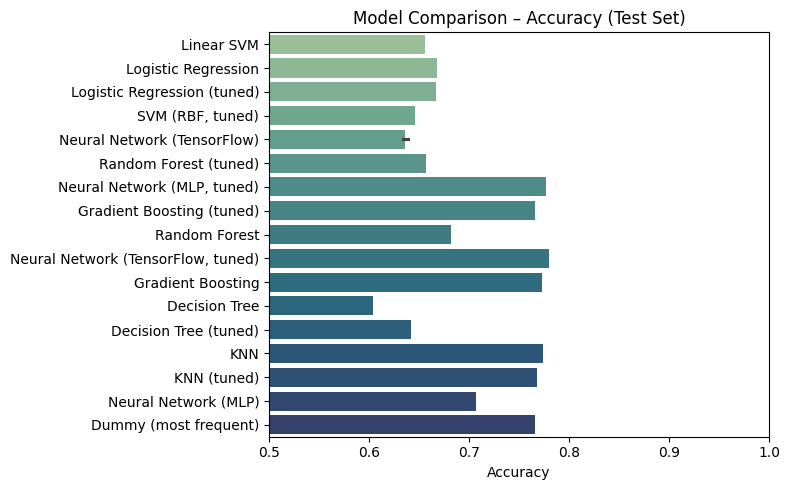

In [322]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=results_sorted,
    x="Accuracy",
    y="Model",
    palette="crest"
)
plt.title("Model Comparison – Accuracy (Test Set)")
plt.xlabel("Accuracy")
plt.ylabel("")
plt.xlim(0.5, 1.0)
plt.tight_layout()
plt.show()

## **Visual: AUC ranking scatter: Accuracy vs. ROC AUC**

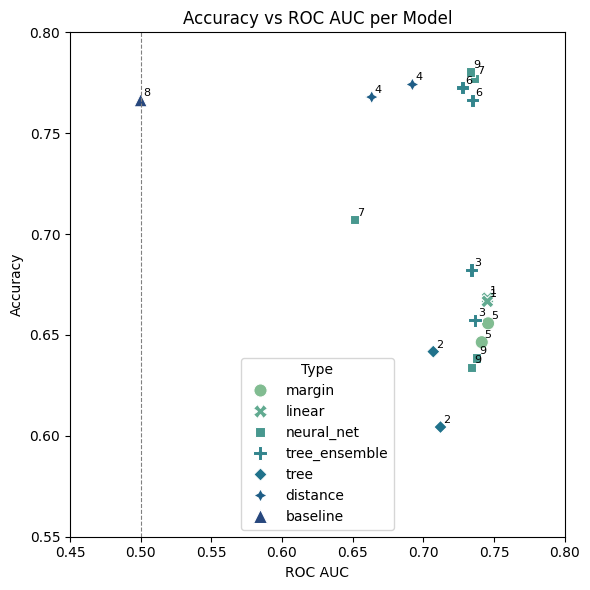

In [323]:
plt.figure(figsize=(6, 6))

sns.scatterplot(
    data=plot_df,
    x="ROC_AUC",
    y="Accuracy",
    hue="Type",
    style="Type",
    s=90,
    palette="crest",
)

for _, row in plot_df.iterrows():
    plt.text(
        x=row["ROC_AUC"] + 0.002,
        y=row["Accuracy"] + 0.002,
        s=str(row["ID"]),      # label by ID to keep it compact
        fontsize=8,
    )

plt.title("Accuracy vs ROC AUC per Model")
plt.xlabel("ROC AUC")
plt.ylabel("Accuracy")
plt.xlim(0.45, 0.8)
plt.ylim(0.55, 0.8)
plt.axhline(0.5, color="grey", linestyle="--", linewidth=0.8)
plt.axvline(0.5, color="grey", linestyle="--", linewidth=0.8)
plt.tight_layout()
plt.show()